# Inferential Statistics III - Bayesian

## Medical charge data set

The hospital is now reviewing its financial resiliency plan, which requires a model for revenue under a range of conditions that include the number of patients treated. Its current model is based on a confidence interval for the mean, and scaling that by different numbers of patients for each scenario. This approach has a number of limitations, most acutely the breakdown of the central limit theorem for low patient volumes; the current model does not do a good job of reflecting the variability in revenue you would see as the number of cases drops. A bootstrap approach would return samples of the same size as the original. Taking subsamples would restrict the sampling to the values already present in the original sample and would not do a good job of representing the actual variability you might see. What is needed is a better model of individual charges.

So the problem here is that we want to model the distribution of individual charges and _we also really want to be able to capture our uncertainty about that distribution_ so we can better capture the range of values we might see. This naturally leads us to a powerful, probabilistic approach — we'll use the pymc3 library to perform Bayesian inference.

### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

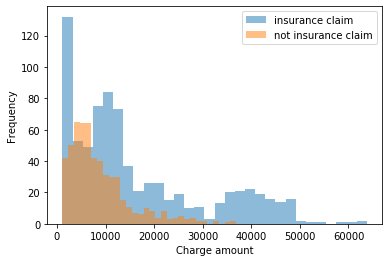

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation

An initial guess for the gamma distribution's $\alpha$ and $\beta$ parameters can be made as described [here](https://wiki.analytica.com/index.php?title=Gamma_distribution).

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

Let's draw the same number of random variates from this distribution and compare to our observed data.

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

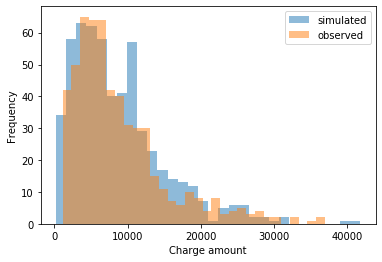

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a _best_ estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

Hint: you may find it helpful to work backwards. Start with your `pm.Gamma`, and note the required stochastic variables `alpha` and `beta`. Then, before that, you need to create those stochastic variables using `pm.Exponential` and the correct parameters.

__A:__

In [10]:
with pm.Model() as model:
    alpha_ = pm.Exponential("alpha", alpha_est)
    rate_ = pm.Exponential("rate", 1/rate_est)

    no_insurance_model = pm.Gamma("gamma",alpha_,rate_, observed=no_insurance)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:13<00:00, 3089.56draws/s]
The number of effective samples is smaller than 25% for some parameters.


__A:__ These plots look reasonably good. The spread of the distributions shown in the histograms is not especially large, and the lineplots are tight. Bad histograms would have a wide distribution and bad lineplots would meander, showing that the steps are not navigating well.

In [11]:
burned_trace = trace[-5000:]
alpha_samples = burned_trace['alpha']
rate_samples = burned_trace['rate']
beta_samples = 1/rate_samples

In [12]:
alpha_ci = np.percentile(alpha_samples, [2.5,97.5])
beta_ci = np.percentile(beta_samples, [2.5,97.5])

print('alpha 95% credible interval: ', alpha_ci)
print('beta 95% credible interval: ', beta_ci)

alpha 95% credible interval:  [1.96728466 2.45719807]
beta 95% credible interval:  [3545.51349859 4553.78680016]


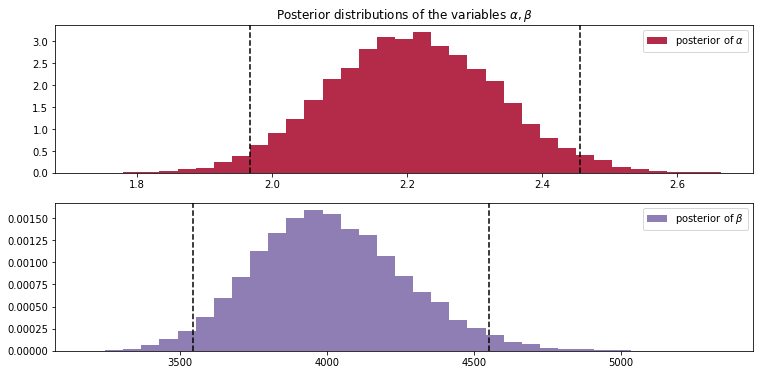

In [13]:
plt.figure(figsize=(12.5, 6))
#Histograms
#code adapted from Probablistic Programming and Bayesian Methods for Hackers, Chapter 2
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.axvline(alpha_ci[0], linestyle='--', color='black')
plt.axvline(alpha_ci[1], linestyle='--', color='black')
plt.legend()
plt.subplot(212)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.axvline(beta_ci[0], linestyle='--', color='black')
plt.axvline(beta_ci[1], linestyle='--', color='black')
plt.legend();

Text(0.5, 0, 'Steps')

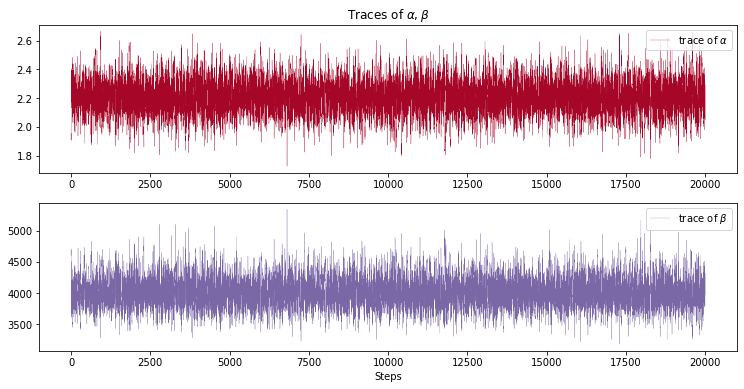

In [14]:
plt.figure(figsize=(12.5, 6))
plt.subplot(211)
plt.title(r"Traces of $\alpha, \beta$")
plt.plot(alpha_samples, label=r"trace of $\alpha$", c="#A60628", lw=0.25)
plt.legend(loc="upper right")

plt.subplot(212)
plt.plot(beta_samples, label=r"trace of $\beta$", c="#7A68A6",lw=0.25)
plt.legend(loc="upper right")
plt.xlabel("Steps")

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__ The traceplots of these data indicate a normal distribution, and the different chains appear to be converging.

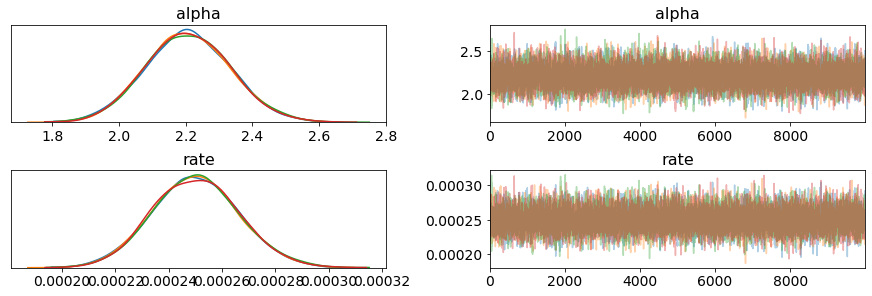

In [15]:
_ = pm.plots.traceplot(trace)

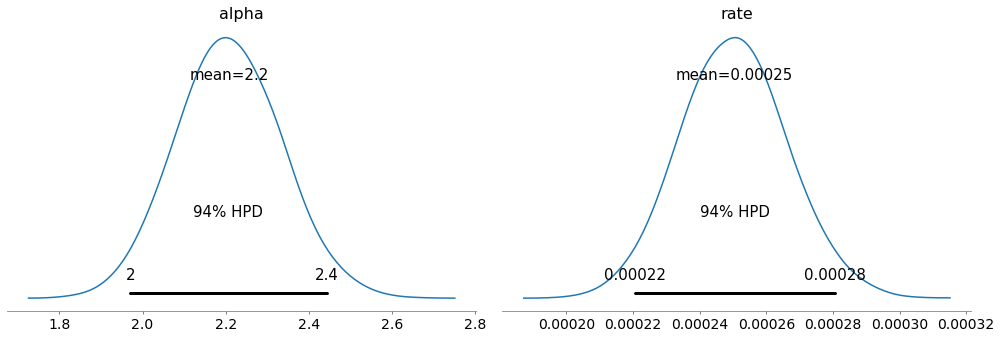

In [16]:
_ = pm.plots.plot_posterior(trace)

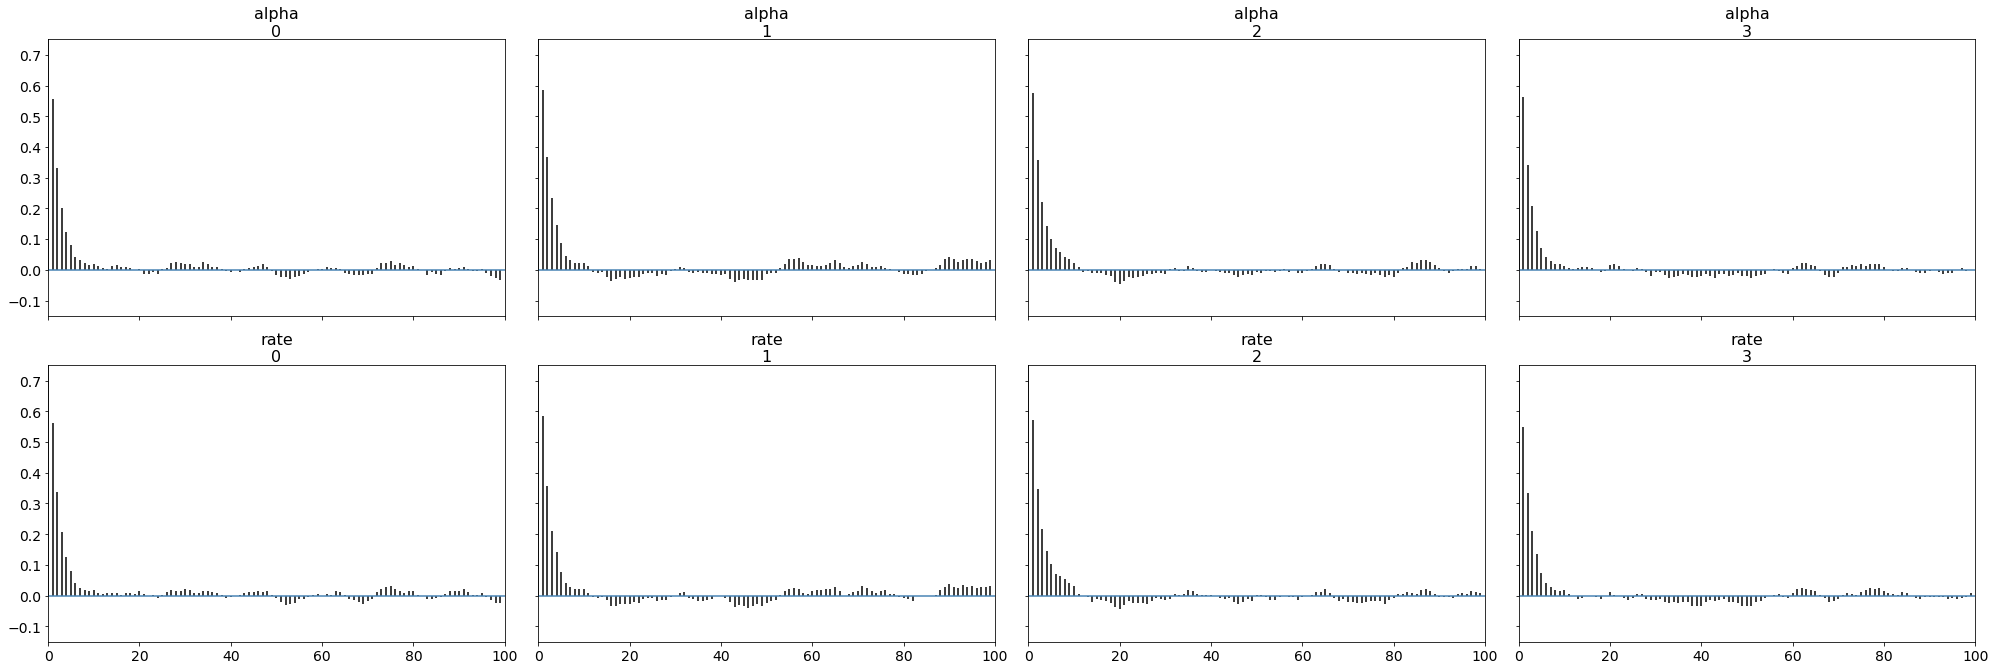

In [17]:
_ = pm.plots.autocorrplot(trace)
_ = plt.ylim([-.15,0.75])

__A:__ The updated simulation appears to fit the observed data better than the initial simulation. However, the updated simulation still skews toward higher values than the observed data, implying that our alpha may still be too low.

In [18]:
seed(47)
best_shot_simulated = gamma(np.mean(alpha_samples), scale=np.mean(beta_samples)).rvs(n_no_ins)

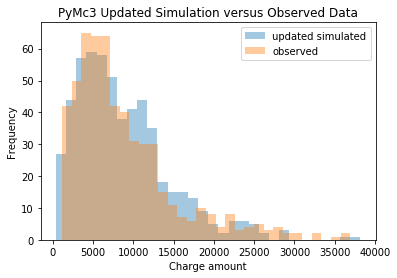

In [20]:
#_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.4, label='simulated')
_ = plt.title("PyMc3 Updated Simulation versus Observed Data")
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.4, label='updated simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.4, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()